<a href="https://colab.research.google.com/github/JaredGlaub/NeuralNetworks/blob/main/MSDS458_Assignment_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/NorthwesternHeader.png?raw=1">

## MSDS458 Research Assignment 3

### Analyze AG_NEWS_SUBSET Data <br>

AG is a collection of more than 1 million news articles. News articles have been gathered from more than 2000 news sources by ComeToMyHead in more than 1 year of activity. ComeToMyHead is an academic news search engine which has been running since July, 2004. The dataset is provided by the academic comunity for research purposes in data mining (clustering, classification, etc), information retrieval (ranking, search, etc), xml, data compression, data streaming, and any other non-commercial activity.<br> 

For more information, please refer to the link http://www.di.unipi.it/~gulli/AG_corpus_of_news_articles.html<br> 


The AG's news topic classification dataset is constructed by choosing 4 largest classes (**World**, **Sports**, **Business**, and **Sci/Tech**) from the original corpus. Each class contains 30,000 training samples and 1,900 testing samples. The total number of training samples is 120,000 and testing 7,600.<br>

Homepage: https://arxiv.org/abs/1509.01626<br>

Source code: tfds.text.AGNewsSubset

Versions:

1.0.0 (default): No release notes.
Download size: 11.24 MiB

Dataset size: 35.79 MiB

<div class="alert alert-block alert-success">
    <b>More Technical</b>: Throughout the notebook. This types of boxes provide more technical details and extra references about what you are seeing. They contain helpful tips, but you can safely skip them the first time you run through the code.
</div>

## Import packages 

In [ ]:
import datetime
import time
from packaging import version
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

!pip install contractions
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import contractions
import tensorflow_hub as hub

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

### Create a Helper Function to Plot Graphs:

In [ ]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

### Verify TensorFlow Version and Keras Version

In [ ]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.5.0


In [ ]:
print("Keras version: ", keras.__version__)

Keras version:  2.5.0


### Mount Google Drive to Colab Environment

In [ ]:
#from google.colab import drive
#drive.mount('/content/gdrive')

###  TensorFlow Datasets Information<br>
<div class="alert alert-block alert-info">
    <b> ag_news_subset</b><br>
    See https://www.tensorflow.org/datasets/catalog/ag_news_subset
    </div>

Get all the words in the documents (as well as the number of words in each document) by using the encoder to get the indices associated with each token and then translating the indices to tokens. But first we need to get the "unpadded" new articles so that we can get their length.

In [ ]:
#register  ag_news_subset so that tfds.load doesn't generate a checksum (mismatch) error
!python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums --datasets=ag_news_subset

# https://www.tensorflow.org/datasets/splits
# The full `train` and `test` splits, interleaved together.
ri = tfds.core.ReadInstruction('train') + tfds.core.ReadInstruction('test')
dataset_all, info = tfds.load('ag_news_subset', with_info=True,  split=ri, as_supervised=True)

2021-08-07 22:25:19.572747: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
I0807 22:25:21.596404 139726654343040 download_and_prepare.py:200] Running download_and_prepare for dataset(s):
ag_news_subset
I0807 22:25:21.597107 139726654343040 dataset_info.py:361] Load dataset info from /root/tensorflow_datasets/ag_news_subset/1.0.0
I0807 22:25:21.598375 139726654343040 download_and_prepare.py:138] download_and_prepare for dataset ag_news_subset/1.0.0...
I0807 22:25:21.598575 139726654343040 dataset_builder.py:299] Reusing dataset ag_news_subset (/root/tensorflow_datasets/ag_news_subset/1.0.0)
name: "ag_news_subset"
description: "AG is a collection of more than 1 million news articles.\nNews articles have been gathered from more than 2000  news sources by ComeToMyHead in more than 1 year of activity.\nComeToMyHead is an academic news search engine which has been running since July, 2004.\nThe dataset is provided by the 

###  Exploratory Analysis AG News Subset

**Get information about the ag_news_subset dataset. We combined the training and test data for a total of 127,600 news articles.**

In [ ]:
print(info)

tfds.core.DatasetInfo(
    name='ag_news_subset',
    version=1.0.0,
    description='AG is a collection of more than 1 million news articles.
News articles have been gathered from more than 2000  news sources by ComeToMyHead in more than 1 year of activity.
ComeToMyHead is an academic news search engine which has been running since July, 2004.
The dataset is provided by the academic comunity for research purposes in data mining (clustering, classification, etc),
information retrieval (ranking, search, etc), xml, data compression, data streaming,
and any other non-commercial activity.
For more information, please refer to the link http://www.di.unipi.it/~gulli/AG_corpus_of_news_articles.html .

The AG's news topic classification dataset is constructed by Xiang Zhang (xiang.zhang@nyu.edu) from the dataset above.
It is used as a text classification benchmark in the following paper:
Xiang Zhang, Junbo Zhao, Yann LeCun. Character-level Convolutional Networks for Text Classification. Advanc

In [ ]:
tfds.as_dataframe(dataset_all.take(10),info)

,description,label
0,"AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial transactions.",3 (Sci/Tech)
1,Reuters - Major League Baseball\Monday announced a decision on the appeal filed by Chicago Cubs\pitcher Kerry Wood regarding a suspension stemming from an\incident earlier this season.,1 (Sports)
2,"President Bush #39;s quot;revenue-neutral quot; tax reform needs losers to balance its winners, and people claiming the federal deduction for state and local taxes may be in administration planners #39; sights, news reports say.",2 (Business)
3,"Britain will run out of leading scientists unless science education is improved, says Professor Colin Pillinger.",3 (Sci/Tech)
4,"London, England (Sports Network) - England midfielder Steven Gerrard injured his groin late in Thursday #39;s training session, but is hopeful he will be ready for Saturday #39;s World Cup qualifier against Austria.",1 (Sports)
5,TOKYO - Sony Corp. is banking on the \$3 billion deal to acquire Hollywood studio Metro-Goldwyn-Mayer Inc...,0 (World)
6,"Giant pandas may well prefer bamboo to laptops, but wireless technology is helping researchers in China in their efforts to protect the engandered animals living in the remote Wolong Nature Reserve.",3 (Sci/Tech)
7,"VILNIUS, Lithuania - Lithuania #39;s main parties formed an alliance to try to keep a Russian-born tycoon and his populist promises out of the government in Sunday #39;s second round of parliamentary elections in this Baltic country.",0 (World)
8,Witnesses in the trial of a US soldier charged with abusing prisoners at Abu Ghraib have told the court that the CIA sometimes directed abuse and orders were received from military command to toughen interrogations.,0 (World)
9,"Dan Olsen of Ponte Vedra Beach, Fla., shot a 7-under 65 Thursday to take a one-shot lead after two rounds of the PGA Tour qualifying tournament.",1 (Sports)


In [ ]:
first100 = pd.DataFrame(tfds.as_dataframe(dataset_all.take(100),info))
# first100.loc(['description'])
# first100.iloc[:1]
first100.iloc[15, 0]

b'London, Oct 04 - Thierry Henry scored twice as arsenal easily beat Charlton 4-0 to extend its unbeaten premier league streak to 48 matches and bounce back from alleged team disunity.'

### Review Labels (Categories) 

In [ ]:
print(f'There are {info.features["label"].num_classes} classes in the dataset.')
print(f'The class names are {info.features["label"].names}')

There are 4 classes in the dataset.
The class names are ['World', 'Sports', 'Business', 'Sci/Tech']


In [ ]:
# classes dictionary
categories =dict(enumerate(info.features["label"].names))
categories

{0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'}

The 127,600 news articles are evenly distributed among the 4 categories

In [ ]:
train_categories = [categories[label] for label in dataset_all.map(lambda text, label: label).as_numpy_iterator()]
Counter(train_categories).most_common()

[('Sci/Tech', 31900), ('Sports', 31900), ('Business', 31900), ('World', 31900)]

In [ ]:
# create new dataset_all with " 39#s" replaced by "'s"

We will use the tf.keras.layers.experimental.preprocessing.TextVectorization layer to transform each news article into a "list" of non-negative integers representing the tokens in the news article.

For the purpose of training our models each such "encoding" will have a fixed length corresponding to the news article(s) with the most tokens. Shorter articles will be right-padded with zeros in the encoding. Also to speed up the training process, we will set max_tokens = 1000 so that words not in the vabulary set of top 1000 most common tokes are encoded as 1. But first we set max_tokens = None (which is the default value) in order to get the vocabulary size of the corpus.


In [ ]:
%%time
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=None)
encoder.adapt(dataset_all.map(lambda text, label: text))
vocab = np.array(encoder.get_vocabulary())

Cause: could not parse the source code of <function <lambda> at 0x7fe0600820e0>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7fe0600820e0>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7fe0600820e0>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
CPU times: user 1min 29s, sys: 16.5 s, total: 1min 46s
Wall time: 1min 22s


In [ ]:
print(f"There are {len(vocab)} vocabulary words in the corpus.")

There are 95976 vocabulary words in the corpus.


There are 95976 vocabulary words in the corpus.

The .adapt method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency:

In [ ]:
vocab[:20]

array(['', '[UNK]', 'the', 'a', 'to', 'of', 'in', 'and', 'on', 'for',
       'that', '39s', 'with', 'its', 'as', 'at', 'is', 'said', 'by', 'it'],
      dtype='<U150')

Let us get the total number of words in the corpus and the sizes of the news articles

In [ ]:
%%time
doc_sizes = []
corpus = []
for example, _ in dataset_all.as_numpy_iterator():
  enc_example = encoder(example)
  doc_sizes.append(len(enc_example))
  corpus+=list(enc_example.numpy())

CPU times: user 10min 42s, sys: 1min 3s, total: 11min 45s
Wall time: 9min 9s


In [ ]:
print(f"There are {len(corpus)} words in the corpus of {len(doc_sizes)} news articles.")
print(f"Each news article has between {min(doc_sizes)} and {max(doc_sizes)} tokens in it.")

There are 3909695 words in the corpus of 127600 news articles.
Each news article has between 3 and 173 tokens in it.


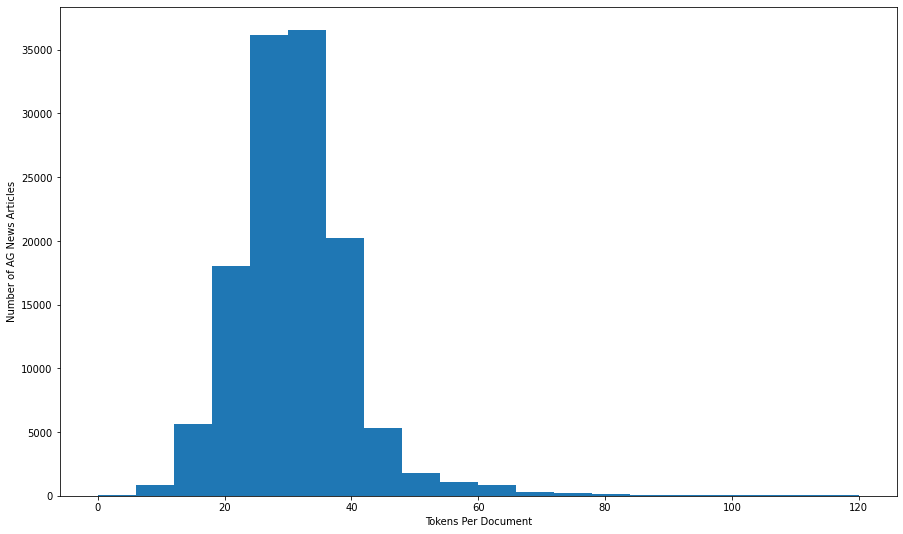

In [ ]:
plt.figure(figsize=(15,9))
plt.hist(doc_sizes, bins=20,range = (0,120))
plt.xlabel("Tokens Per Document")
plt.ylabel("Number of AG News Articles");

Encode the news articles using the top 1000 most common words in the corpus

In [ ]:
%%time
encoder_1000 = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=1000)
encoder_1000.adapt(dataset_all.map(lambda text, label: text))
vocab_1000 = np.array(encoder_1000.get_vocabulary());

Cause: could not parse the source code of <function <lambda> at 0x7fe00629e0e0>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7fe00629e0e0>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7fe00629e0e0>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
CPU times: user 1min 29s, sys: 16.6 s, total: 1min 45s
Wall time: 47.9 s


The .adapt method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency:

In [ ]:
vocab_1000[:20]

array(['', '[UNK]', 'the', 'a', 'to', 'of', 'in', 'and', 'on', 'for',
       'that', '39s', 'with', 'its', 'as', 'at', 'is', 'said', 'by', 'it'],
      dtype='<U14')

In particular, 0 is use for padding, 1 for the unknown words, 2 for the common word, i.e. 'the', etc. Let us look at the same example we encoded previously using the encoder for all the vocabulary words. Note that there are now five 1's denoting words that are not in the top 1000 in frequency.

We encode the same example as before using the new encoder. Note that there are now 5 out of vocabulary words.

In [ ]:
example = "the dog ran after a red ball as it rolled by the hat on the ground."
encoder_1000(example)

<tf.Tensor: shape=(16,), dtype=int64, numpy=
array([  2,   1,   1,  29,   3, 232,   1,  14,  19,   1,  18,   2,   1,
         8,   2, 999])>

In [ ]:
for word in example.split():
  print(f'"{word}" is {"*not* " if word not in vocab_1000  else ""}in the vocabulary.')

"the" is in the vocabulary.
"dog" is *not* in the vocabulary.
"ran" is *not* in the vocabulary.
"after" is in the vocabulary.
"a" is in the vocabulary.
"red" is in the vocabulary.
"ball" is *not* in the vocabulary.
"as" is in the vocabulary.
"it" is in the vocabulary.
"rolled" is *not* in the vocabulary.
"by" is in the vocabulary.
"the" is in the vocabulary.
"hat" is *not* in the vocabulary.
"on" is in the vocabulary.
"the" is in the vocabulary.
"ground." is *not* in the vocabulary.


We want to determine the number of non-vocabulary words in each news articles (denoted by 1s in the encoding)

In [ ]:
%%time
doc1000_sizes = []
corpus1000 = []
count1000=0
useless = 0
# stop = 0
percents = []
for example, _ in dataset_all.as_numpy_iterator():
  # stop+=1
  # if stop > 5: break
  enc_example = encoder_1000(example)
  num_ones = tf.math.count_nonzero(enc_example==1).numpy()
  percent_ones = round(num_ones*100/len(enc_example))
  # print(f"{percent_ones}%")
  percents.append(percent_ones)

  s = set(list(enc_example.numpy()))
  if s == {1}: useless+=1

  doc1000_sizes.append(len(enc_example))
  corpus1000+=list(enc_example.numpy())

  count1000 += tf.math.count_nonzero(enc_example>1)

CPU times: user 12min 41s, sys: 1min 11s, total: 13min 53s
Wall time: 10min 59s


In [ ]:
print(f"Each news article has between {min(doc1000_sizes)} and {max(doc1000_sizes)} tokens in it.")

Each news article has between 3 and 173 tokens in it.


In [ ]:
Counter(percents).most_common(10)
np.unique(percents, return_counts=True) 

(array([  0,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
         15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
         41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
         54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
         67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
         80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
         93,  95,  97, 100]),
 array([  12,    5,   20,   29,   49,   71,  120,  137,  172,  274,  486,
         368,  682,  777,  828, 1346, 1376, 2123, 1610, 2863, 2687, 3018,
        3957, 3315, 4605, 3934, 4148, 5737, 4954, 5072, 6123, 6165, 3255,
        5095, 4596, 3438, 5880, 4205, 3109, 4063, 3555, 3030, 2904, 2294,
        1967, 1716, 2174,  368, 2486,  234, 1246,  747,  573,  547,  520,
         441,  348,  217,  250,  135,  234,   49,  131,  101,   11,  135,
          40,  

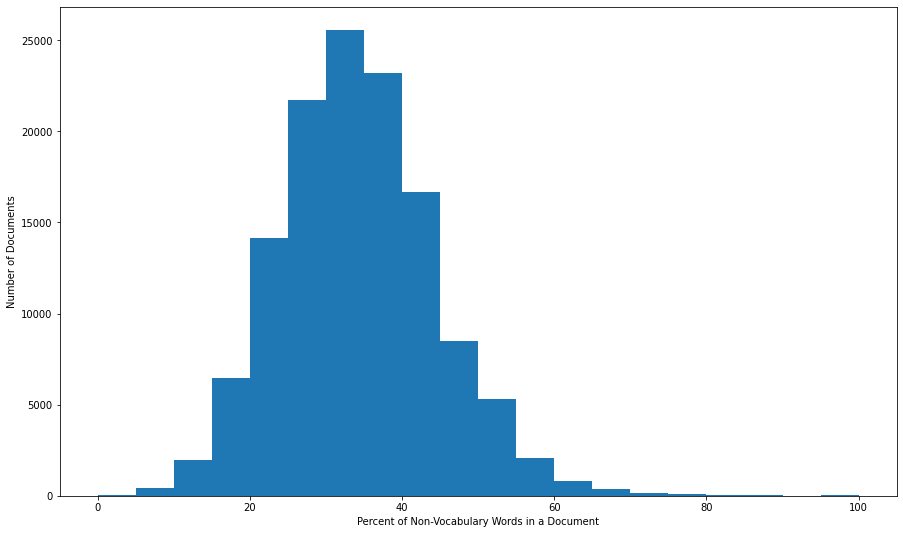

In [ ]:
plt.figure(figsize=(15,9))
plt.hist(percents, 20)
plt.ylabel('Number of Documents')
plt.xlabel('Percent of Non-Vocabulary Words in a Document');

In [ ]:
print(f"There are {count1000} top {len(vocab_1000)} vocabulary words in the corpus.")

There are 2602670 top 1000 vocabulary words in the corpus.


### Preprocessing Data Create Input Pipeline

In [ ]:
# register  ag_news_subset so that tfds.load doesn't generate a checksum (mismatch) error
!python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums --datasets=ag_news_subset

dataset, info = tfds.load('ag_news_subset', with_info=True,  split=['train[:95%]','train[95%:]', 'test[:]'],
                          as_supervised=True)
train_dataset, validation_dataset, test_dataset = dataset

2021-08-07 22:48:03.163113: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
I0807 22:48:05.097481 140450629269376 download_and_prepare.py:200] Running download_and_prepare for dataset(s):
ag_news_subset
I0807 22:48:05.098100 140450629269376 dataset_info.py:361] Load dataset info from /root/tensorflow_datasets/ag_news_subset/1.0.0
I0807 22:48:05.099294 140450629269376 download_and_prepare.py:138] download_and_prepare for dataset ag_news_subset/1.0.0...
I0807 22:48:05.099468 140450629269376 dataset_builder.py:299] Reusing dataset ag_news_subset (/root/tensorflow_datasets/ag_news_subset/1.0.0)
name: "ag_news_subset"
description: "AG is a collection of more than 1 million news articles.\nNews articles have been gathered from more than 2000  news sources by ComeToMyHead in more than 1 year of activity.\nComeToMyHead is an academic news search engine which has been running since July, 2004.\nThe dataset is provided by the 

In [ ]:
len(train_dataset),len(validation_dataset),len(test_dataset)

(114000, 6000, 7600)

### Review Distribution of Categorical Labels for the 114000 training data (news articles)

In [ ]:
from collections import Counter
train_categories = [categories[label] for label in train_dataset.map(lambda text, label: label).as_numpy_iterator()]
Counter(train_categories).most_common()

[('Business', 28531), ('Sports', 28495), ('World', 28491), ('Sci/Tech', 28483)]

Review Example with Interger Label(text, label pairs):

Review Example with Interger Label Encoded Classification(text, label pairs):

In [ ]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('class: ', categories[label.numpy()])

text:  b'AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial transactions.'
class:  Sci/Tech


#### Preprocessing Shuffle Data for Training and Create Batches of `(text, label)` pairs:

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [ ]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
validation_dataset = validation_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
for example, label in train_dataset.take(2):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'Singapore Telecommunications Ltd., Southeast Asia #39;s largest phone company, said the popularity of cut-rate calling plans offered by its Australian mobile-phone unit may limit the impact of lower prices on profit.'
 b'Australia #39;s unemployment rate dropped for the second straight month to 5.6 percent in September, the government said Thursday.'
 b'PRINCETON, NJ (CP) - Philadelphia Flyers head coach Ken Hitchcock is joining the coaching staff of Princeton #39;s men #39;s hockey team during the NHL lockout.']

labels:  [2 2 1]
texts:  [b'Reuters - Mount St. Helens spewed more steam and\\ash on Monday, raising concerns about a larger eruption at the\\Washington state volcano that woke last week after 18 years of\\slumber.'
 b'MOSCOW -- Tens of thousands of demonstrators -- many waving banners and flags -- gathered in Moscow #39;s Red Square Tuesday in a show of unity against terrorism after last week #39;s hostage-taking at a school in Beslan in southern Russia.'
 b'Eleve

In [ ]:
for example, label in train_dataset.take(2):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', [categories[n] for n in label.numpy()[:3]])
  print()

texts:  [b' MOSCOW (Reuters) - Explosive of a kind used by Chechen  rebels has been found in one of two airliners that crashed  simultaneously, Russian investigators said, making it look ever  likelier that the disaster was a political attack.'
 b'HOUSE prices are falling at their fastest rate for nine years, according to one of the country #39;s most influential property studies.'
 b'STOLLBERG, Germany If Chancellor Gerhard Schrder wants to understand why his governing Social Democrats will lose votes Sunday in elections in the eastern German states of Brandenburg and Saxony, he need only visit the small town of Stollberg.']

labels:  ['World', 'Business', 'World']

texts:  [b'A federal judge ruled yesterday that Long Term Capital Management, the giant investment fund that nearly imploded in 1998 and received a \\$3.'
 b'CEO Michael Robertson says the Linux company "won\'t be forced into a cut-rate IPO."'
 b"The Google Playboy Interview In Its Entirety\\\\The infamous Playboy Intervie

## Create the Text Encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `experimental.preprocessing.TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:
The processing of each sample contains the following steps:

    standardize each sample (usually lowercasing + punctuation stripping)
    split each sample into substrings (usually words)
    recombine substrings into tokens (usually ngrams)
    index tokens (associate a unique int value with each token)
    transform each sample using this index, either into a vector of ints or a dense float vector.


The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency: 

In [ ]:
VOCAB_SIZE=1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [ ]:
vocab = np.array(encoder.get_vocabulary())
len(vocab)

1000

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'a', 'to', 'of', 'in', 'and', 'on', 'for',
       'that', '39s', 'with', 'its', 'as', 'at', 'is', 'said', 'by', 'it'],
      dtype='<U14')

Here are the 20 least frequent words.

In [ ]:
vocab[-20:]

array(['black', 'turn', 'build', 'countrys', 'advanced', 'whose',
       'crisis', 'create', '23', 'sources', 'body', 'militant', 'hope',
       'event', 'started', 'ready', 'jones', 'lawsuit', 'focus',
       'singapore'], dtype='<U14')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):<br>
Default Batch Size = 32

In [ ]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[  3, 142, 611,   1,  52,  10, 371,   1, 395, 474,   2, 202, 694,
        759,  10, 302,   1,   6,   1,   7, 920,   3, 565,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0],
       [909, 425,   1, 122,   2, 559,  46,   1,  31,   1,  62,   3,   1,
          1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0],
       [  2, 286,   1,   1,   6,  13,   1,   1,   1,   1,   5,   1,   1,
          7,   1,   1,   2, 286,   1,  16, 163,  60, 226, 825,   8,   1,
        108,  34,   2, 167,  37, 334,   8,   2,  96, 552,   1,   1, 220,
          5,   3, 601,   1,   1, 163,  19,  26,  31,  41,   1,   0,   0,
          0,   0,   0,   0,   0,   0]])

With the default settings, the process is not completely reversible. There are three main reasons for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [ ]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'A federal judge ruled yesterday that Long Term Capital Management, the giant investment fund that nearly imploded in 1998 and received a \\$3.'
Round-trip:  a federal judge [UNK] yesterday that long [UNK] capital management the giant investment fund that nearly [UNK] in [UNK] and received a 3                                   

Original:  b'CEO Michael Robertson says the Linux company "won\'t be forced into a cut-rate IPO."'
Round-trip:  ceo michael [UNK] says the linux company [UNK] be [UNK] into a [UNK] [UNK]                                            

Original:  b"The Google Playboy Interview In Its Entirety\\\\The infamous Playboy Interview of Sergey Brin and Larry Page, the Google Guys, is now not only available on newsstands all over the country, but also on the Security Exchange Commission's website because of a possible SEC violation. Now, it will be more difficult ..."
Round-trip:  the google [UNK] [UNK] in its [UNK] [UNK] [UNK] [UNK] of [UNK] [UNK] and [UNK] [UN

## Create the model

![A drawing of the information flow in the model](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/images/bidirectional.png?raw=1)

Above is a diagram of the model. 

1. This model can be build as a `tf.keras.Sequential`.

1. The first layer is the `encoder`, which converts the text to a sequence of token indices.

2. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

  This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

3. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output. 

  * The main advantage to a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

1. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output. 


<div class="alert alert-block alert-info">
    <b>tf.keras.layers.Bidirectional</b><br>
    https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional
    </div>

<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/BidirectionalRNN.png?raw=1">

In [ ]:
num_classes = 4
model = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary())
                              ,output_dim=64
                                # Use masking to handle the variable sequence lengths
                              ,mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # num_classes = 4
])

<div class="alert alert-block alert-success"> 
Please note that we choose to Keras sequential model here since all the layers in the model only have single input and produce single output. </div>

<div class="alert alert-block alert-info"> 
<b>tf.keras.Model</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/Model
</div>  

## Compile Model 

<div class="alert alert-block alert-info">
<b>tf.keras.losses.SparseCategoricalCrossentropy</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy</div>

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4)
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we don not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

The embedding layer [uses masking](../../guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [ ]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


## Train the model

<div class="alert alert-block alert-success">
    <b>Module: tf.keras.callbacks</b></div>

<div class="alert alert-block alert-info">
<b>tf.keras.callbacks.EarlyStopping</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping</div>

<div class="alert alert-block alert-info">
<b>tf.keras.callbacks.ModelCheckpoint</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint</div>

In [ ]:
history = model.fit(train_dataset
                    ,epochs = 200
                    ,validation_data=validation_dataset
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )

Epoch 1/200
1782/1782 [==============================] - 34s 15ms/step - loss: 0.7444 - accuracy: 0.7179 - val_loss: 0.5050 - val_accuracy: 0.8188
Epoch 2/200
1782/1782 [==============================] - 24s 13ms/step - loss: 0.4643 - accuracy: 0.8349 - val_loss: 0.4418 - val_accuracy: 0.8472
Epoch 3/200
1782/1782 [==============================] - 24s 13ms/step - loss: 0.4208 - accuracy: 0.8494 - val_loss: 0.4099 - val_accuracy: 0.8548
Epoch 4/200
1782/1782 [==============================] - 24s 14ms/step - loss: 0.4013 - accuracy: 0.8554 - val_loss: 0.3964 - val_accuracy: 0.8618
Epoch 5/200
1782/1782 [==============================] - 24s 13ms/step - loss: 0.3906 - accuracy: 0.8581 - val_loss: 0.4189 - val_accuracy: 0.8497
Epoch 6/200
1782/1782 [==============================] - 24s 13ms/step - loss: 0.3834 - accuracy: 0.8608 - val_loss: 0.3847 - val_accuracy: 0.8615


In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

119/119 [==============================] - 1s 7ms/step - loss: 0.4055 - accuracy: 0.8501
Test Loss: 0.4055027663707733
Test Accuracy: 0.8501315712928772


## Plotting Performance Metrics - Single Layer Bidirectional RNN

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history_df=pd.DataFrame(history_dict)
history_df.tail(10).round(3)

,loss,accuracy,val_loss,val_accuracy
0,0.744,0.718,0.505,0.819
1,0.464,0.835,0.442,0.847
2,0.421,0.849,0.410,0.855
3,0.401,0.855,0.396,0.862
4,0.391,0.858,0.419,0.850
5,0.383,0.861,0.385,0.862


In [ ]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

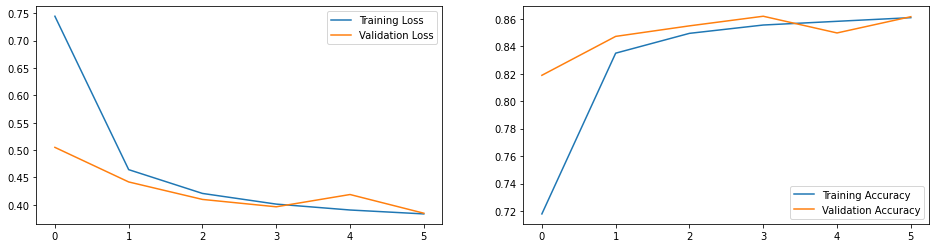

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

## Model Architecture Summary Single Layer Bidirectional RNN

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_2 (TextVe (None, None)              0         
_________________________________________________________________
embedding (Embedding)        (None, None, 64)          64000     
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 260       
Total params: 138,564
Trainable params: 138,564
Non-trainable params: 0
_________________________________________________________________


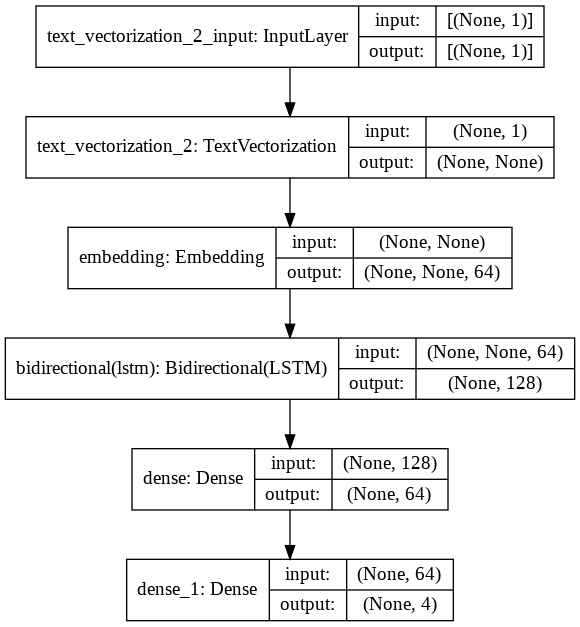

In [ ]:
keras.utils.plot_model(model, "BiDirectionalLSTM.png", show_shapes=True)

## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.

* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:

<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/multilayerBidirectionalLSTM.png?raw=1">

In [ ]:
model2 = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout= 0.5,  return_sequences=True))
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, dropout=0.5))
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dropout(0.5)
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # not binary since there are num_classes categories
])

<div class="alert alert-block alert-info">
<b>tf.keras.losses.SparseCategoricalCrossentropy</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy</div>

In [ ]:
model2.compile(optimizer='adam'
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we do not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [ ]:
history2 = model2.fit(train_dataset
                    ,epochs=200
                    ,validation_data=validation_dataset
                    ,validation_steps=30
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )

Epoch 1/200
1782/1782 [==============================] - 59s 25ms/step - loss: 0.5403 - accuracy: 0.8053 - val_loss: 0.3818 - val_accuracy: 0.8651
Epoch 2/200
1782/1782 [==============================] - 40s 22ms/step - loss: 0.4434 - accuracy: 0.8458 - val_loss: 0.4245 - val_accuracy: 0.8552
Epoch 3/200
1782/1782 [==============================] - 40s 22ms/step - loss: 0.4281 - accuracy: 0.8501 - val_loss: 0.4017 - val_accuracy: 0.8599


In [ ]:
# model.fit(x_nyha, y_nyha, batch_size=batch_size, epochs=num_epochs, verbose=1)
# prediction = np.round(model.predict(x_nyha))
# wrong_predictions = x_nyha[prediction != y_nyha]

In [ ]:
test_loss, test_acc = model2.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

119/119 [==============================] - 1s 9ms/step - loss: 0.4149 - accuracy: 0.8530
Test Loss: 0.4149487018585205
Test Accuracy: 0.8530263304710388


## Plotting Performance Metrics - Multi-Layer Bidirectional RNN

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [ ]:
history_dict2 = history2.history
history_dict2.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history2_df=pd.DataFrame(history_dict2)
history2_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
0,0.540,0.805,0.382,0.865
1,0.443,0.846,0.424,0.855
2,0.428,0.850,0.402,0.860


In [ ]:
losses = history2.history['loss']
accs = history2.history['accuracy']
val_losses = history2.history['val_loss']
val_accs = history2.history['val_accuracy']
epochs = len(losses)

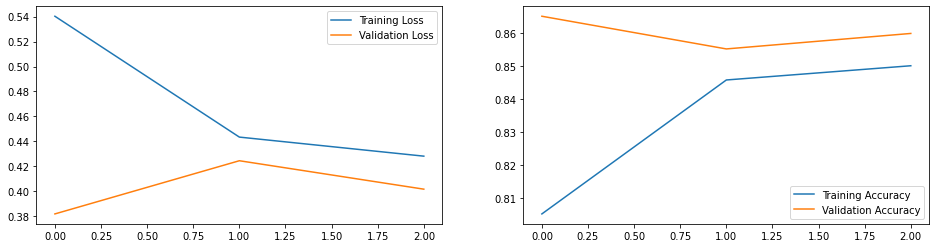

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

### Confusion Matrix

In [ ]:
preds = model2.predict(test_dataset)

In [ ]:
preds.shape

(7600, 4)

In [ ]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [ ]:
df = pd.DataFrame(preds[0:64]
                  ,columns = ['World','Sports','Business','Sci/Tech'])
df.style.format("{:.2%}").background_gradient(cmap=cm)

,World,Sports,Business,Sci/Tech
0,0.18%,99.82%,0.00%,0.00%
1,99.93%,0.01%,0.04%,0.03%
2,0.18%,0.04%,5.32%,94.45%
3,0.79%,99.17%,0.02%,0.02%
4,99.92%,0.00%,0.04%,0.04%
5,0.49%,0.17%,15.28%,84.07%
6,0.61%,99.35%,0.02%,0.03%
7,3.85%,95.70%,0.05%,0.40%
8,96.23%,0.34%,0.76%,2.68%
9,0.65%,0.03%,83.34%,15.98%


In [ ]:
# df[1].max

df['Max Value'] = df.apply(np.max,axis=1)
df['Max ID'] = df.idxmax(axis=1)

df

,World,Sports,Business,Sci/Tech,Max Value,Max ID
0,0.001778,0.998163,0.000021,0.000038,0.998163,Sports
1,0.999304,0.000077,0.000351,0.000268,0.999304,World
2,0.001820,0.000430,0.053244,0.944506,0.944506,Sci/Tech
3,0.007925,0.991673,0.000157,0.000245,0.991673,Sports
4,0.999182,0.000041,0.000361,0.000416,0.999182,World
...,...,...,...,...,...,...
59,0.005740,0.000159,0.722525,0.271576,0.722525,Business
60,0.999408,0.000067,0.000223,0.000302,0.999408,World
61,0.004676,0.994782,0.000156,0.000387,0.994782,Sports
62,0.013854,0.984389,0.000744,0.001013,0.984389,Sports


In [ ]:
result_threshold = df[df['Max Value'] < 0.80]
result_threshold

,World,Sports,Business,Sci/Tech,Max Value,Max ID
17,0.063682,0.003183,0.184599,0.748536,0.748536,Sci/Tech
18,0.003088,0.000282,0.600323,0.396308,0.600323,Business
19,0.617146,0.000334,0.048126,0.334394,0.617146,World
28,0.019041,0.007598,0.662249,0.311112,0.662249,Business
31,0.138478,0.421152,0.076663,0.363707,0.421152,Sports
33,0.141997,0.541552,0.079752,0.236700,0.541552,Sports
35,0.102915,0.050726,0.273206,0.573154,0.573154,Sci/Tech
36,0.729055,0.003158,0.051493,0.216294,0.729055,World
37,0.759708,0.112336,0.041025,0.086931,0.759708,World
39,0.108715,0.125361,0.392597,0.373327,0.392597,Business


In [ ]:
# for example, label in test_dataset.take(1):
#   print('text: ', example.numpy())
example.numpy()[48]
# commonality of buzzwords for both section, consider allowing multiple categories if article max val < threshold

b"Reuters - Refugee camps in Chad housing\\200,000 Sudanese fleeing fighting in Darfur are near capacity\\and placing a huge burden on Sudan's impoverished western\\neighbor, the United Nations said Friday."

#### Model Architecture Summary Single Layer Bidirectional RNN

In [ ]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_2 (TextVe (None, None)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 64)          64000     
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 128)         66048     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                

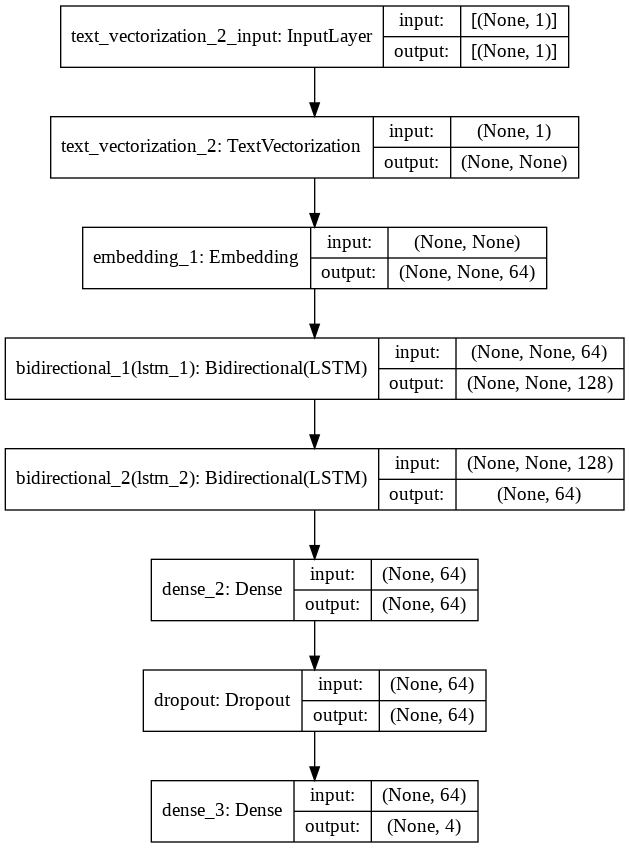

In [ ]:
keras.utils.plot_model(model2, "2Layer_BiDirectionalLSTM.png", show_shapes=True)

Check out other existing recurrent layers such as [GRU layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU).

If you're interestied in building custom RNNs, see the [Keras RNN Guide](../../guide/keras/rnn.ipynb).


## Experiments

### Data Pre-processing

In [ ]:
# view strings
first100 = pd.DataFrame(tfds.as_dataframe(train_dataset.take(10),info))
first100['description']

0    [b"AP - This year's presidential election bega...
1    [b'Dell gets set to roll out its PowerEdge 185...
2    [b'SAN FRANCISCO - Researchers on Monday unvei...
3    [b'p2pnet.net News:- Windows XP users should c...
4    [b'Friday product launch will count on music p...
5    [b"NEW YORK - CBS News appointed former U.S. A...
6    [b'Electronic Arts on Friday began shipping th...
7    [b'WE stand on the brink of a historic agreeme...
8    [b'Eric Shelton ran for three touchdowns and N...
9    [b'Worried about spyware? spam? "spim"? AOL wa...
Name: description, dtype: object

In [ ]:
# create example
text = '''I'll be there within 5 min. Shouldn't you be there too? 
          I'd love to see u there my dear. It's awesome to meet new friends.
          We've been waiting for this day for so long.'''
  
# creating an empty list
expanded_words = []    
for word in text.split():
  # expand the shortened words
  expanded_words.append(contractions.fix(word))   
    
expanded_text = ' '.join(expanded_words)
print('Original text: ' + text)
print('Expanded_text: ' + expanded_text)

Original text: I'll be there within 5 min. Shouldn't you be there too? 
          I'd love to see u there my dear. It's awesome to meet new friends.
          We've been waiting for this day for so long.
Expanded_text: I will be there within 5 min. should not you be there too? I would love to see you there my dear. it is awesome to meet new friends. we have been waiting for this day for so long.


In [ ]:
# re-download dataset for new cleaning
!python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums --datasets=ag_news_subset

dataset, info = tfds.load('ag_news_subset', with_info=True,  split=['train[:95%]','train[95%:]', 'test[:]'],
                          as_supervised=True)
train_dataset, validation_dataset, test_dataset = dataset

2021-08-08 19:38:20.132945: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
I0808 19:38:22.070483 140461561911168 download_and_prepare.py:200] Running download_and_prepare for dataset(s):
ag_news_subset
2021-08-08 19:38:22.080982: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2021-08-08 19:38:22.168847: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2021-08-08 19:38:22.240954: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
I0808 19:38:22.313605 140461561911168 dataset_info.py:434] Load pre-computed DatasetInfo (eg: splits, num examples,...) from GC

In [ ]:
# create dataframes from pre-fetched dataset
train = pd.DataFrame(tfds.as_dataframe(train_dataset.take(len(train_dataset)),info))
valid = pd.DataFrame(tfds.as_dataframe(validation_dataset.take(len(validation_dataset)),info))
test = pd.DataFrame(tfds.as_dataframe(test_dataset.take(len(test_dataset)),info))

In [ ]:
test.head(5)

,description,label
0,"b' CHARLOTTE, N.C. (Sports Network) - Carolina...",1
1,"b' PRESENTACION, Philippines (Reuters) - Phili...",0
2,"b'SAN FRANCISCO, CA - November 30, 2004 -Ubiso...",3
3,b'DANIEL VETTORI spun New Zealand to the brink...,1
4,"b""AFP - Georgian and South Ossetian forces ove...",0


In [ ]:
# manipulate descriptions into more usable strings
# training set
documents = []
stemmer = WordNetLemmatizer()
length = len(train['description'])

for sen in range(0, length):
    # Remove all the special characters
    document = re.sub(r'\W', ' ', str(train['description'][sen]))
    
    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    
    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
    
    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    
    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)
    
    # Removing quot
    document = re.sub(r'quot', '', document)

    # Removing 39
    document = re.sub(r'39', '', document)

    # Converting to Lowercase
    document = document.lower()
    
    # Lemmatization
    document = document.split()

    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)
    
    documents.append(document)

In [ ]:
clean_train = pd.DataFrame(documents)
clean_train['label'] = train['label']
clean_train.rename(columns = {0:'description'}, inplace = True)

In [ ]:
# validation
documents = []
stemmer = WordNetLemmatizer()
length = len(valid['description'])

for sen in range(0, length):
    # Remove all the special characters
    document = re.sub(r'\W', ' ', str(valid['description'][sen]))
    
    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    
    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
    
    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    
    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)
    
    # Removing quot
    document = re.sub(r'quot', '', document)

    # Removing 39
    document = re.sub(r'39', '', document)

    # Converting to Lowercase
    document = document.lower()
    
    # Lemmatization
    document = document.split()

    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)
    
    documents.append(document)

In [ ]:
clean_valid = pd.DataFrame(documents)
clean_valid['label'] = valid['label']
clean_valid.rename(columns = {0:'description'}, inplace = True)

In [ ]:
# test
documents = []
stemmer = WordNetLemmatizer()
length = len(test['description'])

for sen in range(0, length):
    # Remove all the special characters
    document = re.sub(r'\W', ' ', str(test['description'][sen]))
    
    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    
    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
    
    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    
    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)
    
    # Removing quot
    document = re.sub(r'quot', '', document)

    # Removing 39
    document = re.sub(r'39', '', document)

    # Converting to Lowercase
    document = document.lower()
    
    # Lemmatization
    document = document.split()

    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)
    
    documents.append(document)

In [ ]:
clean_test = pd.DataFrame(documents)
clean_test['label'] = test['label']
clean_test.rename(columns = {0:'description'}, inplace = True)

In [ ]:
train_examples = clean_train['description']
train_labels = clean_train['label']

valid_examples = clean_valid['description']
valid_labels = clean_valid['label']

test_examples = clean_test['description']
test_labels = clean_test['label']

In [ ]:
# combine into a cleaned dataset
frames = [clean_train, clean_valid, clean_test]
clean_dataset = pd.concat(frames)

In [ ]:
clean_dataset.iloc[len(train)][0] #check that positions are correct

'bm plan to announce today that it will invest 250 million over the next five year and employ 1 000 people in new business unit to support product and service related to sensor network'

### Initial Benchmark

In [ ]:
# initialize list for training times
train_times = []

In [ ]:
# get text embeddings from tensorflow hub, use as first layer in networks
hub_model = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(hub_model, input_shape=[], dtype=tf.string, trainable=True)

benchmark = tf.keras.Sequential([
                            hub_layer
                            ,tf.keras.layers.Dense(4,activation='softmax')
])

In [ ]:
benchmark.compile(optimizer='adam'
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we do not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [ ]:
start = time.process_time()

benchmark_history = benchmark.fit(train_examples
                    ,train_labels                
                    ,epochs=20
                    ,validation_data=(valid_examples, valid_labels)
                    ,batch_size = 500
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )

stop = time.process_time()
runtime = stop - start
train_times.append(runtime)

Epoch 1/20
228/228 [==============================] - 4s 17ms/step - loss: 0.6967 - accuracy: 0.8077 - val_loss: 0.3983 - val_accuracy: 0.8845
Epoch 2/20
228/228 [==============================] - 4s 16ms/step - loss: 0.3303 - accuracy: 0.9021 - val_loss: 0.3140 - val_accuracy: 0.8985
Epoch 3/20
228/228 [==============================] - 4s 17ms/step - loss: 0.2620 - accuracy: 0.9186 - val_loss: 0.2894 - val_accuracy: 0.9058
Epoch 4/20
228/228 [==============================] - 4s 16ms/step - loss: 0.2252 - accuracy: 0.9288 - val_loss: 0.2810 - val_accuracy: 0.9083
Epoch 5/20
228/228 [==============================] - 4s 16ms/step - loss: 0.1993 - accuracy: 0.9369 - val_loss: 0.2790 - val_accuracy: 0.9080
Epoch 6/20
228/228 [==============================] - 4s 16ms/step - loss: 0.1793 - accuracy: 0.9429 - val_loss: 0.2824 - val_accuracy: 0.9062


In [ ]:
test_loss, test_acc = benchmark.evaluate(test_examples,test_labels)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

benchmarkacc = test_acc
benchmarkloss = test_loss

238/238 [==============================] - 1s 3ms/step - loss: 0.2896 - accuracy: 0.9057
Test Loss: 0.2896190881729126
Test Accuracy: 0.9056578874588013


### Experiment Set 1

In [ ]:
hub_model = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(hub_model, input_shape = [], dtype = tf.string, trainable = True)

# Parameter grid for grid search
param_grid = dict(num_filters=[32, 64, 128],
                  kernelSize=[3, 5, 7],
                  poolSize = [3, 5, 7]
                  )

def create_model(num_filters, kernelSize, poolSize):
  model = tf.keras.Sequential([
                        hub_layer
                        ,tf.keras.layers.Reshape((1,50)) 
                        ,tf.keras.layers.Conv1D(num_filters, kernel_size = kernelSize, padding = "same", activation = 'tanh')
                        ,tf.keras.layers.MaxPooling1D(pool_size = poolSize, padding = "same", strides = 3)
                        ,tf.keras.layers.Conv1D(num_filters, kernel_size = kernelSize, padding = "same", activation = 'tanh')
                        ,tf.keras.layers.MaxPooling1D(pool_size = poolSize, padding = "same", strides = 3)              
                        ,tf.keras.layers.Dense(512, activation = 'tanh')
                        ,tf.keras.layers.Dropout(0.7)
                        ,tf.keras.layers.Dense(4,activation='softmax')
                        ])
  model.compile(optimizer = 'adam', loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics = ['accuracy'])
  return model

In [ ]:
# Main settings
epochs = 10
output_file = 'output.txt'


# Parameter grid for grid search
param_grid = dict(num_filters=[64, 128, 256],
                  kernelSize=[3, 5, 7],
                  poolSize = [3, 5, 7]
                  )

model = KerasClassifier(build_fn=create_model,
                        epochs=epochs,
                        verbose=False)

grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=9)
grid_result = grid.fit(train_examples
                ,train_labels                
                ,epochs=epochs
                ,validation_data=(valid_examples, valid_labels)
                ,batch_size = 500
                ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                )

# Evaluate testing set
test_accuracy = grid.score(test_examples, test_labels)

# Save and evaluate results
with open(output_file, 'a') as f:
    s = ('Best Accuracy : '
        '{:.4f}\n{}\nTest Accuracy : {:.4f}\n\n')
    output_string = s.format(
        grid_result.best_score_,
        grid_result.best_params_,
        test_accuracy)
    print(output_string)
    f.write(output_string)

paramSearch1 = pd.DataFrame(grid.cv_results_)
paramSearch1

Best Accuracy : 0.9835
{'poolSize': 3, 'num_filters': 64, 'kernelSize': 7}
Test Accuracy : 0.8405




,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_poolSize,param_num_filters,param_kernelSize,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,13.418956,1.707214,3.706452,2.548630,5,256,7,"{'poolSize': 5, 'num_filters': 256, 'kernelSiz...",0.898377,0.930965,0.931842,0.950526,0.951140,0.932570,0.019181,9
1,13.263046,3.038037,4.399380,4.011250,5,256,3,"{'poolSize': 5, 'num_filters': 256, 'kernelSiz...",0.958421,0.955132,0.961403,0.953377,0.967588,0.959184,0.005025,8
2,10.824486,1.224631,2.462303,0.296811,5,64,5,"{'poolSize': 5, 'num_filters': 64, 'kernelSize...",0.968860,0.970307,0.969868,0.970044,0.970746,0.969965,0.000627,7
3,11.638548,1.552270,2.477931,0.215977,3,128,3,"{'poolSize': 3, 'num_filters': 128, 'kernelSiz...",0.971140,0.971009,0.973860,0.974123,0.976667,0.973360,0.002108,5
4,16.704987,4.676997,2.475609,0.014786,3,256,5,"{'poolSize': 3, 'num_filters': 256, 'kernelSiz...",0.975307,0.970746,0.965482,0.974561,0.978640,0.972947,0.004498,6
5,10.904021,0.668398,2.481711,0.176889,7,128,3,"{'poolSize': 7, 'num_filters': 128, 'kernelSiz...",0.982544,0.981974,0.979079,0.978947,0.983289,0.981167,0.001808,3
6,18.118498,4.900602,2.470591,0.053751,7,256,3,"{'poolSize': 7, 'num_filters': 256, 'kernelSiz...",0.982544,0.975702,0.970789,0.978640,0.976623,0.976860,0.003840,4
7,10.832964,1.239725,2.369377,0.052639,3,64,3,"{'poolSize': 3, 'num_filters': 64, 'kernelSize...",0.982895,0.982018,0.978202,0.982895,0.983553,0.981912,0.001918,2
8,10.915240,1.230623,3.952497,3.109041,3,64,7,"{'poolSize': 3, 'num_filters': 64, 'kernelSize...",0.984781,0.981272,0.982939,0.983026,0.985263,0.983456,0.001431,1


### Experiment Set 2

In [ ]:
hub_model = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(hub_model, input_shape = [], dtype = tf.string, trainable = True)

# Parameter grid for grid search
param_grid = dict(num_filters=[64, 128, 256],
                  kernelSize=[3, 5, 7],
                  poolSize = [3, 5, 7]
                  )

def create_model_2(num_filters, kernelSize, poolSize):
  model = tf.keras.Sequential([
                        hub_layer
                        ,tf.keras.layers.Reshape((1,50)) 
                        ,tf.keras.layers.Conv1D(num_filters, kernel_size = kernelSize, padding = "same", activation='relu')
                        ,tf.keras.layers.MaxPooling1D(pool_size = poolSize, padding = "same", strides = 3)
                        ,tf.keras.layers.Conv1D(num_filters, kernel_size = kernelSize, padding = "same", activation='relu')
                        ,tf.keras.layers.MaxPooling1D(pool_size = poolSize, padding = "same", strides = 3)              
                        ,tf.keras.layers.Dense(512, activation = 'relu')
                        ,tf.keras.layers.Dropout(0.7)
                        ,tf.keras.layers.Dense(4,activation='softmax')
                        ])
  model.compile(optimizer = 'adam', loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics = ['accuracy'])
  return model

In [ ]:
# Main settings
output_file = 'output2.txt'

model = KerasClassifier(build_fn = create_model_2,
                        epochs = epochs,
                        verbose = False)

grid = RandomizedSearchCV(estimator = model, param_distributions = param_grid, n_iter = 9)
grid_result = grid.fit(train_examples
                ,train_labels                
                ,epochs = epochs
                ,validation_data = (valid_examples, valid_labels)
                ,batch_size = 500
                ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                )

# Evaluate testing set
test_accuracy = grid.score(test_examples, test_labels)

# Save and evaluate results
with open(output_file, 'a') as f:
    s = ('Best Accuracy : '
        '{:.4f}\n{}\nTest Accuracy : {:.4f}\n\n')
    output_string = s.format(
        grid_result.best_score_,
        grid_result.best_params_,
        test_accuracy)
    print(output_string)
    f.write(output_string)

paramSearch2 = pd.DataFrame(grid.cv_results_)
paramSearch2

Best Accuracy : 0.9934
{'poolSize': 3, 'num_filters': 64, 'kernelSize': 5}
Test Accuracy : 0.8643




,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_poolSize,param_num_filters,param_kernelSize,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,11.494299,1.349912,2.374992,0.013082,5,128,5,"{'poolSize': 5, 'num_filters': 128, 'kernelSiz...",0.904123,0.935789,0.944781,0.952061,0.959254,0.939202,0.019187,9
1,15.024718,5.396521,4.471368,4.059380,3,256,3,"{'poolSize': 3, 'num_filters': 256, 'kernelSiz...",0.945175,0.971974,0.968640,0.974693,0.974868,0.967070,0.011179,8
2,10.156056,0.023333,2.813899,0.359740,5,64,3,"{'poolSize': 5, 'num_filters': 64, 'kernelSize...",0.974605,0.977412,0.977763,0.978553,0.981491,0.977965,0.002210,7
3,16.713540,3.503178,2.429615,0.018789,5,256,5,"{'poolSize': 5, 'num_filters': 256, 'kernelSiz...",0.976491,0.984956,0.981491,0.985658,0.986184,0.982956,0.003624,6
4,13.406868,4.891213,6.550782,7.330866,3,64,7,"{'poolSize': 3, 'num_filters': 64, 'kernelSize...",0.986097,0.987632,0.985833,0.986009,0.983772,0.985868,0.001231,5
5,14.487099,4.170550,3.041735,0.886723,3,64,3,"{'poolSize': 3, 'num_filters': 64, 'kernelSize...",0.989868,0.985877,0.989035,0.988684,0.991360,0.988965,0.001798,4
6,13.849810,3.954391,2.420670,0.030654,7,256,3,"{'poolSize': 7, 'num_filters': 256, 'kernelSiz...",0.992939,0.988596,0.990044,0.992412,0.990614,0.990921,0.001585,3
7,17.465072,2.605093,2.456451,0.022648,3,256,7,"{'poolSize': 3, 'num_filters': 256, 'kernelSiz...",0.992675,0.991316,0.992193,0.992632,0.993465,0.992456,0.000702,2
8,10.207431,0.038387,2.667675,0.619186,3,64,5,"{'poolSize': 3, 'num_filters': 64, 'kernelSize...",0.994386,0.993070,0.992368,0.993202,0.993728,0.993351,0.000675,1


### Experiment Set 3

In [ ]:
hub_model = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(hub_model, input_shape = [], dtype = tf.string, trainable = True)

param_grid = dict(num_filters=[32, 64, 128],
                  dropoutPercent = [0.6, 0.7, 0.8]
                  )

def create_model_3(num_filters, dropoutPercent):
    model = tf.keras.Sequential([
                          hub_layer
                          ,tf.keras.layers.Reshape((1,50)) 
                          ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(num_filters, dropout = dropoutPercent,  return_sequences=True))
                          ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(num_filters, dropout = dropoutPercent))          
                          ,tf.keras.layers.Dense(512, activation = 'relu')
                          ,tf.keras.layers.Dropout(dropoutPercent)
                          ,tf.keras.layers.Dense(4,activation = 'softmax')
                          ])
    model.compile(optimizer = 'adam', loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics = ['accuracy'])
    return model

In [ ]:
output_file = 'output3.txt'

model = KerasClassifier(build_fn = create_model_3,
                        epochs = epochs,
                        verbose = False)

grid = RandomizedSearchCV(estimator = model, param_distributions = param_grid, n_iter=9)
grid_result = grid.fit(train_examples
                ,train_labels                
                ,epochs = epochs
                ,validation_data = (valid_examples, valid_labels)
                ,batch_size = 500
                ,callbacks = [tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 2)]
                )

# Evaluate testing set
test_accuracy = grid.score(test_examples, test_labels)

# Save and evaluate results
with open(output_file, 'a') as f:
    s = ('Best Accuracy : '
        '{:.4f}\n{}\nTest Accuracy : {:.4f}\n\n')
    output_string = s.format(
        grid_result.best_score_,
        grid_result.best_params_,
        test_accuracy)
    print(output_string)
    f.write(output_string)

paramSearch3 = pd.DataFrame(grid.cv_results_)
paramSearch3

Best Accuracy : 0.9761
{'num_filters': 128, 'dropoutPercent': 0.8}
Test Accuracy : 0.8878




,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_num_filters,param_dropoutPercent,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,21.529477,5.378400,6.785394,6.323656,32,0.6,"{'num_filters': 32, 'dropoutPercent': 0.6}",0.911009,0.935088,0.948070,0.952456,0.956184,0.940561,0.016403,9
1,17.459497,0.712308,3.648646,0.060985,64,0.6,"{'num_filters': 64, 'dropoutPercent': 0.6}",0.953947,0.956754,0.959956,0.962632,0.963728,0.959404,0.003639,8
2,18.514998,2.082393,3.903596,0.545663,128,0.6,"{'num_filters': 128, 'dropoutPercent': 0.6}",0.960044,0.967412,0.967018,0.966930,0.971447,0.966570,0.003672,7
3,17.651502,0.712003,3.614769,0.047155,32,0.7,"{'num_filters': 32, 'dropoutPercent': 0.7}",0.970219,0.973114,0.970000,0.969342,0.972544,0.971044,0.001497,6
4,17.485863,0.685235,7.149455,4.316060,64,0.7,"{'num_filters': 64, 'dropoutPercent': 0.7}",0.972719,0.974518,0.972281,0.971447,0.974781,0.973149,0.001294,5
5,18.554957,2.108419,6.780899,3.543154,128,0.7,"{'num_filters': 128, 'dropoutPercent': 0.7}",0.975833,0.976140,0.974123,0.972939,0.975395,0.974886,0.001192,4
6,17.163949,0.492841,5.705897,3.489791,32,0.8,"{'num_filters': 32, 'dropoutPercent': 0.8}",0.976535,0.978158,0.974211,0.973246,0.974649,0.975360,0.001761,3
7,18.195243,1.247377,3.647213,0.082972,64,0.8,"{'num_filters': 64, 'dropoutPercent': 0.8}",0.975526,0.977588,0.974605,0.974123,0.976272,0.975623,0.001231,2
8,17.800024,0.850048,3.673770,0.024375,128,0.8,"{'num_filters': 128, 'dropoutPercent': 0.8}",0.975833,0.977061,0.975921,0.974605,0.976886,0.976061,0.000880,1


### Confusion Matrix for Best Model

In [ ]:
preds = exp1.predict((test_examples,test_labels))

In [ ]:
preds.shape

(7600, 4)

In [ ]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [ ]:
df = pd.DataFrame(preds[0:64]
                  ,columns = ['World','Sports','Business','Sci/Tech'])
df.style.format("{:.2%}").background_gradient(cmap=cm)

,World,Sports,Business,Sci/Tech
0,0.00%,99.99%,0.01%,0.00%
1,99.97%,0.01%,0.01%,0.01%
2,0.00%,0.00%,0.11%,99.89%
3,0.77%,99.16%,0.06%,0.01%
4,97.73%,0.18%,0.48%,1.61%
5,0.13%,0.05%,6.65%,93.17%
6,0.04%,99.84%,0.06%,0.06%
7,0.32%,99.68%,0.00%,0.00%
8,99.89%,0.01%,0.04%,0.07%
9,8.18%,0.52%,88.73%,2.57%


In [ ]:
# df[1].max

df['Max Value'] = df.apply(np.max,axis=1)
df['Max ID'] = df.idxmax(axis=1)

df

,World,Sports,Business,Sci/Tech,Max Value,Max ID
0,2.781609e-05,0.999880,0.000086,0.000007,0.999880,Sports
1,9.996980e-01,0.000067,0.000131,0.000103,0.999698,World
2,2.710044e-06,0.000004,0.001119,0.998874,0.998874,Sci/Tech
3,7.686416e-03,0.991649,0.000570,0.000095,0.991649,Sports
4,9.772832e-01,0.001826,0.004795,0.016096,0.977283,World
...,...,...,...,...,...,...
59,4.997788e-03,0.001392,0.716582,0.277029,0.716582,Business
60,9.999062e-01,0.000077,0.000005,0.000013,0.999906,World
61,7.859763e-03,0.987679,0.000593,0.003869,0.987679,Sports
62,1.860864e-01,0.556803,0.253866,0.003244,0.556803,Sports


In [ ]:
result_threshold = df[df['Max Value'] < 0.65]
result_threshold

,World,Sports,Business,Sci/Tech,Max Value,Max ID
18,0.000161,0.000272,0.450762,0.548805,0.548805,Sci/Tech
31,0.020207,0.473564,0.291213,0.215016,0.473564,Sports
36,0.520034,0.001476,0.409108,0.069381,0.520034,World
37,0.521106,0.037675,0.376015,0.065204,0.521106,World
39,0.285482,0.082813,0.507130,0.124575,0.507130,Business
40,0.607362,0.003411,0.087506,0.301722,0.607362,World
42,0.587955,0.007321,0.400764,0.003960,0.587955,World
48,0.475558,0.008001,0.408069,0.108373,0.475558,World
51,0.036797,0.005676,0.328303,0.629225,0.629225,Sci/Tech
56,0.002725,0.002689,0.614840,0.379746,0.614840,Business


In [ ]:
test_examples[31], test_labels[31]
#unstoppable, legend, winner typical to sport, "dot com burst may not be part of dictionary or appears differently"

('individually theyve been unstoppable in their respective industry theyre both legend that have survived the dot com burst and came out winner',
 3)

In [ ]:
test_labels[18], test_labels[31], test_labels[36], test_labels[37], test_labels[39], test_labels[40], test_labels[42], test_labels[48], test_labels[51], test_labels[56], test_labels[62]

(2, 3, 0, 3, 3, 0, 0, 2, 3, 2, 1)

In [ ]:
categories
# x: business not sci/tech
# x: sci/tech not sports
# o
# x: sci/tech not world
# x: sci/Tech not business
# o
# o
# x: business not world
# o
# o
# o

{0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'}

### Benchmark Performance Plotted

In [ ]:
history_dictionary = exp1_history.history
history_dictionary.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history_dictionary_df=pd.DataFrame(history_dictionary)
history_dictionary_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
2,0.264,0.918,0.292,0.908
3,0.227,0.928,0.284,0.908
4,0.201,0.936,0.281,0.909
5,0.181,0.942,0.283,0.908
6,0.165,0.948,0.288,0.904


In [ ]:
losses = exp1_history.history['loss']
accs = exp1_history.history['accuracy']
val_losses = exp1_history.history['val_loss']
val_accs = exp1_history.history['val_accuracy']
epochs = len(losses)

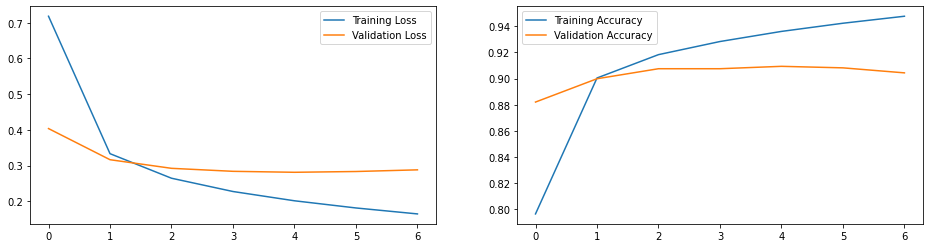

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

#### Final Plot

In [ ]:
# for comparing individual networks from experimental sets
hub_model = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(hub_model, input_shape=[], dtype=tf.string, trainable=True)

expset1 = tf.keras.Sequential([
                          hub_layer
                          ,tf.keras.layers.Reshape((1,50)) 
                          ,tf.keras.layers.Conv1D(64, kernel_size= 7, padding = "same", activation='tanh')
                          ,tf.keras.layers.MaxPooling1D(pool_size=3, padding = "same",strides=3)
                          ,tf.keras.layers.Conv1D(64, kernel_size= 7, padding = "same", activation='tanh')
                          ,tf.keras.layers.MaxPooling1D(pool_size=3, padding = "same",strides=3)    
                          ,tf.keras.layers.Dense(500, activation='tanh')
                          ,tf.keras.layers.Dropout(0.7)
                          ,tf.keras.layers.Dense(4,activation='softmax')
                          ])
expset1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_3 (KerasLayer)   (None, 50)                48190600  
_________________________________________________________________
reshape_3 (Reshape)          (None, 1, 50)             0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 1, 64)             22464     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 1, 64)             0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 1, 64)             28736     
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 1, 64)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 1, 500)           

In [ ]:
expset1.compile(optimizer='adam'
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we do not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [ ]:
start = time.process_time()

expset1_history = expset1.fit(train_examples
                    ,train_labels                
                    ,epochs=20
                    ,validation_data=(valid_examples, valid_labels)
                    ,batch_size = 500
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )

stop = time.process_time()
runtime = stop - start
train_times.append(runtime)

Epoch 1/20
228/228 [==============================] - 5s 19ms/step - loss: 0.4282 - accuracy: 0.8600 - val_loss: 0.3014 - val_accuracy: 0.9008
Epoch 2/20
228/228 [==============================] - 4s 18ms/step - loss: 0.2521 - accuracy: 0.9166 - val_loss: 0.2840 - val_accuracy: 0.9072
Epoch 3/20
228/228 [==============================] - 4s 18ms/step - loss: 0.2008 - accuracy: 0.9329 - val_loss: 0.2932 - val_accuracy: 0.9053
Epoch 4/20
228/228 [==============================] - 4s 18ms/step - loss: 0.1677 - accuracy: 0.9446 - val_loss: 0.3128 - val_accuracy: 0.9005


In [ ]:
test_loss, test_acc = expset1.evaluate(test_examples,test_labels)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))
expset1loss = test_loss
expset1acc = test_acc

238/238 [==============================] - 1s 4ms/step - loss: 0.3214 - accuracy: 0.8984
Test Loss: 0.3213789463043213
Test Accuracy: 0.898421049118042


In [ ]:
# for comparing individual networks from experimental sets
hub_model = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(hub_model, input_shape=[], dtype=tf.string, trainable=True)

expset2 = tf.keras.Sequential([
                          hub_layer
                          ,tf.keras.layers.Reshape((1,50)) 
                          ,tf.keras.layers.Conv1D(64, kernel_size= 7, padding = "same", activation='relu')
                          ,tf.keras.layers.MaxPooling1D(pool_size=3, padding = "same",strides=3)
                          ,tf.keras.layers.Conv1D(64, kernel_size= 7, padding = "same", activation='relu')
                          ,tf.keras.layers.MaxPooling1D(pool_size=3, padding = "same",strides=3)    
                          ,tf.keras.layers.Dense(500, activation='relu')
                          ,tf.keras.layers.Dropout(0.7)
                          ,tf.keras.layers.Dense(4,activation='softmax')
                          ])
expset2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_5 (KerasLayer)   (None, 50)                48190600  
_________________________________________________________________
reshape_5 (Reshape)          (None, 1, 50)             0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 1, 64)             22464     
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 1, 64)             0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 1, 64)             28736     
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 1, 64)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 1, 500)           

In [ ]:
expset2.compile(optimizer='adam'
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we do not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [ ]:
start = time.process_time()

expset2_history = expset2.fit(train_examples
                    ,train_labels                
                    ,epochs=20
                    ,validation_data=(valid_examples, valid_labels)
                    ,batch_size = 500
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )

stop = time.process_time()
runtime = stop - start
train_times.append(runtime)

Epoch 1/20
228/228 [==============================] - 5s 20ms/step - loss: 0.4730 - accuracy: 0.8411 - val_loss: 0.2916 - val_accuracy: 0.9040
Epoch 2/20
228/228 [==============================] - 4s 19ms/step - loss: 0.2513 - accuracy: 0.9182 - val_loss: 0.2723 - val_accuracy: 0.9083
Epoch 3/20
228/228 [==============================] - 4s 19ms/step - loss: 0.2001 - accuracy: 0.9350 - val_loss: 0.2787 - val_accuracy: 0.9082
Epoch 4/20
228/228 [==============================] - 4s 19ms/step - loss: 0.1640 - accuracy: 0.9463 - val_loss: 0.3000 - val_accuracy: 0.9038


In [ ]:
test_loss, test_acc = expset2.evaluate(test_examples,test_labels)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))
expset2loss = test_loss
expset2acc = test_acc

238/238 [==============================] - 1s 4ms/step - loss: 0.3058 - accuracy: 0.9053
Test Loss: 0.3058261275291443
Test Accuracy: 0.9052631855010986


In [ ]:
# for comparing individual networks from experimental sets
hub_model = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(hub_model, input_shape=[], dtype=tf.string, trainable=True)

expset3 = tf.keras.Sequential([
                      hub_layer
                      ,tf.keras.layers.Reshape((1,50)) 
                      ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, dropout = 0.8,  return_sequences=True))
                      ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, dropout = 0.8))          
                      ,tf.keras.layers.Dense(512, activation='relu')
                      ,tf.keras.layers.Dropout(0.8)
                      ,tf.keras.layers.Dense(4,activation='softmax')
                      ])
expset3.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_6 (KerasLayer)   (None, 50)                48190600  
_________________________________________________________________
reshape_6 (Reshape)          (None, 1, 50)             0         
_________________________________________________________________
bidirectional (Bidirectional (None, 1, 256)            183296    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               394240    
_________________________________________________________________
dense_9 (Dense)              (None, 512)               131584    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 4)                

In [ ]:
expset3.compile(optimizer='adam'
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we do not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [ ]:
start = time.process_time()

expset3_history = expset3.fit(train_examples
                    ,train_labels                
                    ,epochs=20
                    ,validation_data=(valid_examples, valid_labels)
                    ,batch_size = 500
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )

stop = time.process_time()
runtime = stop - start
train_times.append(runtime)

Epoch 1/20
228/228 [==============================] - 11s 26ms/step - loss: 0.7107 - accuracy: 0.7289 - val_loss: 0.3435 - val_accuracy: 0.8832
Epoch 2/20
228/228 [==============================] - 5s 21ms/step - loss: 0.4313 - accuracy: 0.8552 - val_loss: 0.3084 - val_accuracy: 0.8963
Epoch 3/20
228/228 [==============================] - 5s 21ms/step - loss: 0.3722 - accuracy: 0.8780 - val_loss: 0.2921 - val_accuracy: 0.9042
Epoch 4/20
228/228 [==============================] - 5s 21ms/step - loss: 0.3368 - accuracy: 0.8913 - val_loss: 0.2827 - val_accuracy: 0.9075
Epoch 5/20
228/228 [==============================] - 5s 21ms/step - loss: 0.3123 - accuracy: 0.8996 - val_loss: 0.2794 - val_accuracy: 0.9097
Epoch 6/20
228/228 [==============================] - 5s 20ms/step - loss: 0.2935 - accuracy: 0.9074 - val_loss: 0.2743 - val_accuracy: 0.9112
Epoch 7/20
228/228 [==============================] - 5s 20ms/step - loss: 0.2749 - accuracy: 0.9129 - val_loss: 0.2771 - val_accuracy: 0.912

In [ ]:
test_loss, test_acc = expset3.evaluate(test_examples,test_labels)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))
expset3loss = test_loss
expset3acc = test_acc

238/238 [==============================] - 2s 4ms/step - loss: 0.2872 - accuracy: 0.9109
Test Loss: 0.2871600389480591
Test Accuracy: 0.910921037197113


In [ ]:
history_df = pd.DataFrame(expset1_history.history)
history_df = pd.DataFrame(history_df.tail(1).round(3))
#experiment set 2 best
expset2_history_df = pd.DataFrame(expset2_history.history)
expset2_history_df = pd.DataFrame(expset2_history_df.tail(1).round(3))
history_df = history_df.append(expset2_history_df)
#experiment set 3 best
expset3_history_df = pd.DataFrame(expset3_history.history)
expset3_history_df = pd.DataFrame(expset3_history_df.tail(1).round(3))
history_df = history_df.append(expset3_history_df)
#benchmark
benchmark_history_df = pd.DataFrame(benchmark_history.history)
benchmark_history_df = pd.DataFrame(benchmark_history_df.tail(1).round(3))
history_df = history_df.append(benchmark_history_df)

In [ ]:
times = np.zeros(4)
for i in range(0, len(train_times)):
  times[i] = round(train_times[i],2)

In [ ]:
history_df['trainingTime(s)'] = times

In [ ]:
condensed = history_df.iloc[[0,1,2,3],:]
condensed = condensed.reset_index()

In [ ]:
model = ["1D CNN","1D CNN", "Bidirectional RNN", "input + output"]
description = ["tanh", "relu", "0.8 dropout", "only hub layer"]
test_accuracy = [expset1acc, expset2acc, expset3acc, benchmarkacc]

test_loss = [expset1loss, expset2loss, expset3loss, benchmarkloss]

condensed.insert(0, "model", model, allow_duplicates=True)
condensed.insert(1, "description", description, allow_duplicates=True)
condensed = condensed.rename(columns={"index": "epochs"})
condensed.insert(8, "test accuracy", test_accuracy, allow_duplicates=True)
condensed.insert(9, "test loss", test_loss, allow_duplicates=True)
condensed['test accuracy'] = condensed['test accuracy'].round(3)
condensed['test loss'] = condensed['test loss'].round(3)
condensed

,model,description,epochs,loss,accuracy,val_loss,val_accuracy,trainingTime(s),test accuracy,test loss
0,1D CNN,tanh,3,0.168,0.945,0.313,0.900,22.21,0.898,0.321
1,1D CNN,relu,3,0.164,0.946,0.300,0.904,23.12,0.905,0.306
2,Bidirectional RNN,0.8 dropout,11,0.222,0.931,0.279,0.914,82.45,0.911,0.287
3,input + output,only hub layer,5,0.179,0.943,0.282,0.906,28.29,0.906,0.290
